In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nilearn
from nilearn.plotting import plot_stat_map

nilearn.EXPAND_PATH_WILDCARDS = False

In [6]:
from os.path import exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

In [7]:
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.maskers import NiftiLabelsMasker

In [8]:
# fMRI NIfTI ファイル
#func_fn = '/home/sudesnac/01_data/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/sub-001/func/sub-001_task-pieman_run-1_bold.nii.gz'
#func_fn = 'sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz'

func_fn_b = '/home/sudesnac/01_data/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'


# TSVファイルを読み込み（タブ区切り）
df = pd.read_csv("participants_milkyway.tsv", sep="\t")

# 1列目（インデックス0）の要素を配列（リスト）として保存
sub = df.iloc[:, 0].tolist()

task = 'milkyway'
print(len(sub))
num = input()

# 確認用出力
print(sub)
suba=sub[int(num)]

func_fn = func_fn_b+suba+'/func/'+suba+'_task-'+task+'_bold.nii.gz'

# Schaefer atlas (400 parcels, 17 networks)
n_parcels = 400
atlas = fetch_atlas_schaefer_2018(n_rois=n_parcels, yeo_networks=17, resolution_mm=2)

# masker: 各 parcel ごとに平均時系列を取り出す
masker = NiftiLabelsMasker(atlas.maps, labels=atlas.labels, standardize=True)
func_parcels = masker.fit_transform(func_fn)

print("func_parcels shape:", func_parcels.shape)

53


 52


['sub-023', 'sub-030', 'sub-032', 'sub-034', 'sub-038', 'sub-052', 'sub-079', 'sub-081', 'sub-083', 'sub-086', 'sub-087', 'sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-093', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-112', 'sub-113', 'sub-114', 'sub-115', 'sub-116', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122', 'sub-123', 'sub-124', 'sub-125', 'sub-126', 'sub-127', 'sub-128', 'sub-129', 'sub-130', 'sub-131']
[fetch_atlas_schaefer_2018] Dataset found in /home/y-sato/nilearn_data/schaefer_2018


/home/y-sato/venv/.venv/[name]/lib/python3.10/site-packages/sklearn/utils/_set_output.py:316: UserWarning: After resampling the label image to the data image, the following labels were removed: {100.0, 38.0, 40.0, 72.0, 42.0, 43.0, 239.0, 80.0, 81.0, 241.0, 242.0, 243.0, 303.0, 280.0, 281.0}. Label image only contains 386 labels (including background).
  data_to_wrap = f(self, X, *args, **kwargs)


func_parcels shape: (297, 385)


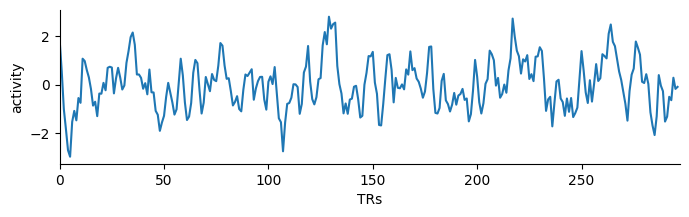

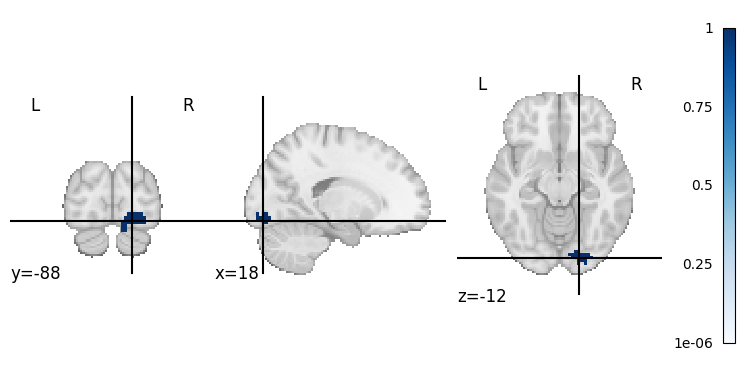

In [9]:
from nilearn.plotting import plot_stat_map

example_parcel = 195
func_parcel = func_parcels[:, example_parcel]

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(func_parcel)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, len(func_parcel)))
sns.despine()

# Plot parcel on MNI atlas
parcels_label = np.zeros(func_parcels.shape[1])
parcels_label[example_parcel] = 1

# Invert masker transform to project onto brain
parcel_img = masker.inverse_transform(parcels_label)
plot_stat_map(parcel_img, cmap='Blues');

In [10]:
# #ERROR IS OCCURRED_cuz out of bounce.
# from surfplot import Plot
# from neuromaps.datasets import fetch_fslr
# from neuromaps.transforms import mni152_to_fslr


# # Fetch fsLR surfaces from neuromaps
# surfaces = fetch_fslr()
# lh, rh = surfaces['inflated']
# sulc_lh, sulc_rh = surfaces['sulc']

# # Convert volumetric MNI data to fsLR surface
# gii_lh, gii_rh = mni152_to_fslr(parcel_img, method='nearest')


# # Plot example ROI on surface
# p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
# p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='Blues', color_range=(0, 1))
# cbar_kws = dict(location='right', draw_border=False, aspect=10,
#                 shrink=.2, decimals=0, pad=0, n_ticks=2)
# fig = p.build(cbar_kws=cbar_kws)

In [11]:
import gensim.downloader

# Download 300-dimensional word2vec embeddings
model_name = 'word2vec-google-news-300'
n_features = 300

model = gensim.downloader.load(model_name)

In [12]:
# Load in transcript CSV file
import pickle

transcript_f = 'milkyway_transcript_dummy.csv'
transcript_w2v = pd.read_csv(transcript_f)

# Convert words to lowercase
transcript_w2v['word'] = transcript_w2v.word.str.lower()

# Function to extract embeddings if available
def get_vector(word):
    if word in model.key_to_index:
        return model.get_vector(word, norm=True).astype(np.float32)
    return np.nan

# Extract embedding for each word
transcript_w2v['embedding'] = transcript_w2v.word.apply(get_vector)  
transcript_w2v = transcript_w2v.astype({'onset': 'float32', 'offset': 'float32'}, copy=False)

# Print out words not found in vocabulary
print(f'{(transcript_w2v.embedding.isna()).sum()} words not found:')
print(transcript_w2v.word[transcript_w2v.embedding.isna()].value_counts())

# Save transcript with embeddings using pickle
with open('milkyway_w2v.pkl', 'wb') as f:
    pickle.dump(transcript_w2v, f)

118 words not found:
word
to         40
a          28
and        25
of          9
i'm         5
andre’s     2
l’amour     1
40          1
i'll        1
10          1
15          1
56          1
20th        1
i've        1
i’ll        1
Name: count, dtype: int64


In [13]:
# Reload transcript with embeddings if already generated
transcript_f = 'milkyway_w2v.pkl'
if exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_w2v = pickle.load(f)

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

# Initialize tokenizer and model
model_name = 'gpt2'
n_features = 768

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Print out model architecture
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
# Get device for running model (e.g. MacOS 'mps')
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

# We might need to force CPU on Mac due to a Pytorch bug with MPS
device = 'cpu'

print(f"Using {device} device")

Using cpu device


In [16]:
# Reload in transcript CSV file
transcript_f = 'milkyway_transcript_dummy.csv'
transcript_gpt2 = pd.read_csv(transcript_f)

# Insert explicit index column for reference
transcript_gpt2.insert(0, 'word_index', transcript_gpt2.index.values)

# Tokenize words into lists of tokens
transcript_gpt2['token'] = transcript_gpt2.word.apply(tokenizer.tokenize)

# "Explode" lists of token subwords into long format
transcript_gpt2 = transcript_gpt2.explode('token', ignore_index=True)

# Convert tokens to token IDs for input to model
transcript_gpt2['token_id'] = transcript_gpt2.token.apply(tokenizer.convert_tokens_to_ids)

In [17]:
# Convert all token IDs into list
token_ids = transcript_gpt2.token_id.tolist()

# Extract context window width for model
max_len = tokenizer.model_max_length

# Compile into lists of tokens within each context window
samples = []
token_ids = torch.tensor(transcript_gpt2.token_id.tolist(), dtype=torch.long)
samples.append(token_ids[0:max_len])
for i in range(max_len+1, len(token_ids)+1):
    samples.append(token_ids[i-max_len:i])

In [18]:
from accelerate import Accelerator

# Initialize accelerator and free memory
accelerator = Accelerator()
accelerator.free_memory()

# Send model to device
model = model.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/y-sato/venv/.venv/[name]/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [19]:
# Set a batch size for the data loader
batch_size = 4

# Extract a late-intermediate layer from GPT-2
layer = 8

# Extract embeddings and other model features
embeddings = []
top_guesses = []
ranks = []
true_probs = []
entropies = []
with torch.no_grad():
    data_loader = torch.utils.data.DataLoader(samples, batch_size=batch_size,
                                              shuffle=False)

    # Loop through samples and extract embeddings
    for i, batch in enumerate(tqdm(data_loader)):
        output = model(batch.to(device), output_hidden_states=True)
        logits = output.logits  # torch.Size([2, 1024, 50257])
        states = output.hidden_states[layer]

        # Extract all embeddings/features for first context window
        if i == 0:
            true_ids = batch[0, :]
            brange = list(range(len(true_ids)-1))
            logits_order = logits[0].argsort(descending=True, dim=-1)
            batch_top_guesses = logits_order[:-1, 0]
            batch_ranks = torch.eq(logits_order[:-1],
                                   true_ids.reshape(-1,1)[1:].to(device)).nonzero()[:, 1]
            batch_probs = logits[0, :-1].softmax(-1)
            batch_true_probs = batch_probs[brange, true_ids[1:]]
            batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
            batch_embeddings = states[0]

            top_guesses.append(batch_top_guesses.numpy(force=True))
            ranks.append(batch_ranks.numpy(force=True))
            true_probs.append(batch_true_probs.numpy(force=True))
            entropies.append(batch_entropy.numpy(force=True))
            embeddings.append(batch_embeddings.numpy(force=True))
            
            # Reset if there are samples remaining in this batch
            if batch.size(0) == 1:
                continue
            logits = logits[1:]
            states = states[1:]
            batch = batch[1:]

        # Extract embeddings/features for last word in subsequent windows
        true_ids = batch[:, -1]
        brange = list(range(len(true_ids)))
        logits_order = logits[:, -2, :].argsort(descending=True)  # batch x vocab_size
        batch_top_guesses = logits_order[:, 0]
        batch_ranks = torch.eq(logits_order, true_ids.reshape(-1,1).to(device)).nonzero()[:, 1]
        batch_probs = torch.softmax(logits[:, -2, :], dim=-1)
        batch_true_probs = batch_probs[brange, true_ids]
        batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
        batch_embeddings = states[:, -1, :]

        top_guesses.append(batch_top_guesses.numpy(force=True))
        ranks.append(batch_ranks.numpy(force=True))
        true_probs.append(batch_true_probs.numpy(force=True))
        entropies.append(batch_entropy.numpy(force=True))
        embeddings.append(batch_embeddings.numpy(force=True))

  0%|          | 0/33 [00:00<?, ?it/s]

In [20]:
# Compile outputs into transcript (logit derivatives must be shifted by 1)
transcript_gpt2.loc[1:, 'rank'] = np.concatenate(ranks)
transcript_gpt2.loc[1:, 'true_prob'] = np.concatenate(true_probs)
transcript_gpt2.loc[1:, 'top_pred'] = np.concatenate(top_guesses)
transcript_gpt2.loc[0, 'top_pred'] = tokenizer.bos_token_id
transcript_gpt2.loc[1:, 'entropy'] = np.concatenate(entropies)
transcript_gpt2['embedding'] = [e for e in np.vstack(embeddings)]

# Reduce size of transcript
transcript_gpt2 = transcript_gpt2.astype({'word_index': 'int32', 'onset': 'float32',
                                      'offset': 'float32', 'token_id': 'int32',
                                      'rank': 'float32', 'true_prob': 'float32',
                                      'top_pred': 'int32', 'entropy': 'float32'}, copy=False)

# Convert model's top predictions from token IDs to tokens
transcript_gpt2['top_pred'] = transcript_gpt2.top_pred.apply(tokenizer.convert_ids_to_tokens)

# Print out top-1 and top-10 word prediction accuracy
print(f"Top-1 accuracy: {(transcript_gpt2['rank'] == 0).mean():.3f}")
print(f"Top-10 accuracy: {(transcript_gpt2['rank'] < 10).mean():.3f}")

# Save transcript with embeddings using pickle
with open('piemanpni_gpt2.pkl', 'wb') as f:
    pickle.dump(transcript_gpt2, f)

Top-1 accuracy: 0.295
Top-10 accuracy: 0.605


In [21]:
# Reload transcript with embeddings if already generated
transcript_f = 'milkyway_gpt2.pkl'
if exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_gpt2 = pickle.load(f)

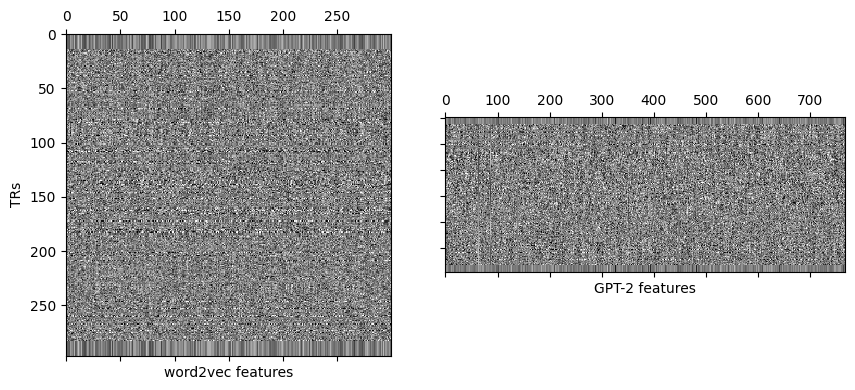

In [22]:
# Function to average embeddings per TR
def construct_predictors(transcript_df, n_features, stim_dur, tr=1.5):

    # Find total number of TRs
    stim_trs = np.ceil(stim_dur / tr)

    # Add column to transcript with TR indices
    transcript_df['TR'] = transcript_df.onset.divide(tr).apply(np.floor).apply(int)
    
    # Compile the words within each TR
    words_per_tr = transcript_df.groupby('TR')['word'].apply(list)
    
    # Average the embeddings within each TR
    embeddings_per_tr = transcript_df.groupby('TR')['embedding'].mean()
    
    # Loop through TRs
    words_trs = []
    embeddings_trs = []
    for t in np.arange(stim_trs):
        if t in words_per_tr:
            words_trs.append(words_per_tr[t])
    
            # Fill in empty TRs with zero vectors
            if embeddings_per_tr[t] is not np.nan:
                embeddings_trs.append(embeddings_per_tr[t])
            else:
                embeddings_trs.append(np.zeros(n_features))
        else:
            words_trs.append([])
            embeddings_trs.append(np.zeros(n_features))
    
    embeddings = np.vstack(embeddings_trs)
    return embeddings

# word2vec embeddings are 300-dimensional
X_w2v = construct_predictors(transcript_w2v, 300, 445.5, tr=1.5)

# GPT-2 embeddings are 768-dimensional
X_gpt2 = construct_predictors(transcript_gpt2, 768, 445.5, tr=1.5)
# Visualize word embedding predictors
from scipy.stats import zscore

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
axs[0].matshow(zscore(X_w2v, axis=0),
               cmap='binary_r', vmin=-3, vmax=3)
axs[0].set(xlabel='word2vec features', ylabel='TRs')
axs[1].matshow(zscore(X_gpt2, axis=0),
               cmap='binary_r', vmin=-3, vmax=3)
axs[1].set(xlabel='GPT-2 features');
plt.tight_layout()

In [23]:
# Trim fMRI data to match embeddings:
#ERROR IS OCCURRED CUZ Y_parcels and assert
start_trs = 14
end_trs = 9

#assert start_trs + X_w2v.shape[0] + end_trs == func_parcels.shape[0]

#Y_parcels = func_parcels[start_trs:-end_trs]
Y_parcels = func_parcels[start_trs : start_trs + X_w2v.shape[0]]

In [24]:
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.pipeline import make_pipeline

# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6, 7.5 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4, 5])

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

In [25]:
# Select embeddings from one of the models
X = X_gpt2

# Loop through outer folds and estimate model
Y_predicted = []
for train, test in outer_cv.split(Y_parcels):
    
    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(X[train],
                 Y_parcels[train])
    
    # Compute predicted response
    predicted = pipeline.predict(X[test])
    Y_predicted.append(predicted)
    
# Restack first and second half predictions
Y_predicted = np.vstack(Y_predicted)

Mean encoding performance: r = 0.092
Maximum encoding performance: r = 0.681


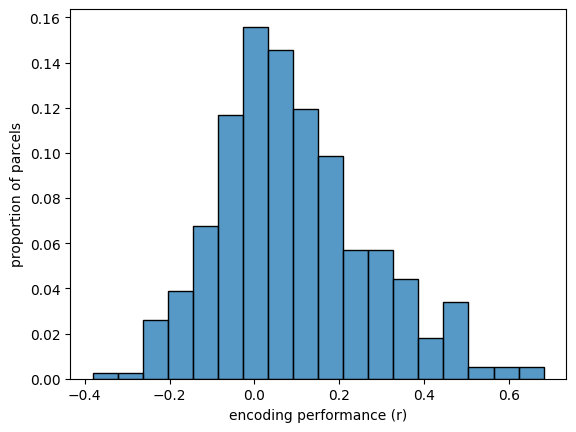

In [26]:
from himalaya.scoring import correlation_score

# Evaluate predictions: correlation between predicted and actual time series
score_parcels = correlation_score(Y_parcels, Y_predicted)

print(f"Mean encoding performance: r = {np.mean(score_parcels):.3f}")
print(f"Maximum encoding performance: r = {np.amax(score_parcels):.3f}")

# Plot a histogram of prediction performance values
fig, ax = plt.subplots()
sns.histplot(score_parcels, stat='proportion', ax=ax)
ax.set(xlabel='encoding performance (r)', ylabel='proportion of parcels');

In [27]:
# Introspect fitted pipeline model for alphas and weights
ridge_fitted = pipeline['kernelridgecv']
best_alphas = ridge_fitted.best_alphas_
weights = ridge_fitted.get_primal_coef(ridge_fitted.X_fit_)

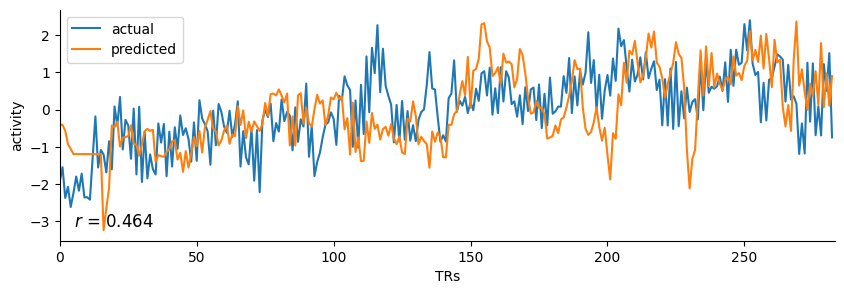

In [29]:
# Plot predicted and actual response for example parcel:
example_parcel = 197
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(zscore(Y_parcels[:, example_parcel]), label='actual')
ax.plot(zscore(Y_predicted[:, example_parcel]), label='predicted')
ax.annotate(f'$\it{{r}}$ = {score_parcels[example_parcel]:.3f}',
            xy=(10, 10), xycoords='axes points', fontsize=12)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, Y_predicted.shape[0]))
ax.legend()
sns.despine()

# 

## 